In [1]:
import os, sys, random
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm, trange
from termcolor import cprint
import pandas as pd
import json
import clip
from torch.utils.data import DataLoader
from PIL import Image
from PIL import ImageFile  # 大きな画像もロード
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
import pickle

device = 'cuda'

In [2]:
def get_language_embedding(prompt:str):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    model = model.eval()
    text = clip.tokenize([prompt]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text)
    print('original text: ', prompt)
    return text_features

def get_image_embedding(image_file:str, show:bool=True):
    model, preprocess = clip.load("ViT-B/32", device=device)
    model = model.eval()
    raw_image = (Image.open(image_file))
    image = preprocess(raw_image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    if show:
        print('original image: ')
        plt.imshow(raw_image)
        plt.show()
    return image_features

def get_IN1k_val_features():
    imagenet_val_root = '/storage/dataset/image/ImageNet/ILSVRC2012_val/'
    with open("/home/yainoue/meg2image/codes/MEG-decoding/data/ImageNet/val_features.pkl", "rb") as f:
        imagenet_data = pickle.load(f)
        imagenet_Y = np.zeros((len(imagenet_data), 512))
        imagenet_name = [None] * len(imagenet_data)
        cnt = 0
        for k, v in imagenet_data.items():
            imagenet_Y[cnt] = v # v: 512
            imagenet_name[cnt] = os.path.join(imagenet_val_root, k)
            cnt += 1
        #         imagenet_Y -= source_dataset.mean_Y
        #         imagenet_Y /= source_dataset.std_Y
        imagenet_Y = torch.Tensor(imagenet_Y).to(device)
    return imagenet_Y, imagenet_name


class Normalize(nn.Module):
    def __init__(self, dim: int) -> None:
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.nn.functional.normalize(x, dim=self.dim, p=2)


    
def embedding_synthesizer(embedding_list:list, preprocess_funcs:list, temps:list=1.0, scale:list=None):
    if isinstance(temps, float):
        temps = [temps] * len(embedding_list)
    assert len(embedding_list) > 0
    for i, e in enumerate(embedding_list):
        temp = temps[i]
        e = e * temp
        for p in preprocess_funcs:
            e = p(e)
        embedding_list[i] = e if scale is None else e*scale[i]
    new_embedding = embedding_list[0]
    for e in embedding_list[1:]:
        new_embedding += e
    new_embedding /= len(new_embedding)
    return new_embedding

def retain_topk(database, query:torch.Tensor, batch_size:int=64, topk:int=5):
    if query.ndim == 1:
        query = query.unsqueeze(0)
    assert query.ndim == 2
    
    if isinstance(database, torch.Tensor):
        cos_similarity = torch.nn.functional.cosine_similarity(database, query, dim=1, eps=1e-8)
    else:
        cos_similarity = []
        total_steps = len(database) // batch_size
        residual_samples = len(database) % batch_size
        for s in range(total_steps):
            start_id = s * batch_size
            end_id = start_id + batch_size
            batch_data = torch.Tensor(database[start_id:end_id])
            cos_similarity.append(torch.nn.functional.cosine_similarity(database, query, dim=1, eps=1e-8))
        batch_data = torch.Tensor(database[-residual_samples:])
        cos_similarity.append(torch.nn.functional.cosine_similarity(database, query, dim=1, eps=1e-8))
        cos_similarity = torch.cat(cos_similarity, dim=0)
        
    topk_candidates = torch.argsort(cos_similarity, descending=True)[:topk]
    
    return topk_candidates

def show_image_list(image_file_list:list):
    fig, axes = plt.subplots(ncols=len(image_file_list), figsize=(5*len(image_file_list), 4))
    for i, image_file in enumerate(image_file_list):
        raw_image = (Image.open(image_file))
        axes[i].imshow(raw_image)
    plt.show()


In [3]:
original_image_file_path = '/storage/dataset/ECoG/internal/GODv2-4/images_val/n03452741_24622.JPEG'
original_prompt = 'playing the piano'
image_features = get_image_embedding(original_image_file_path, show=True)
text_features = get_language_embedding(original_prompt)

database, database_names = get_IN1k_val_features()
database_with_original = torch.cat([database, image_features], dim=0)
database_names_with_original = database_names + [original_image_file_path]

KeyboardInterrupt: 

# Can retain the same image?

In [93]:
topk_candidates =  retain_topk(database_with_original, image_features, batch_size=64, topk=5)

tensor([50000, 11076, 49420, 11078, 33499], device='cuda:0')


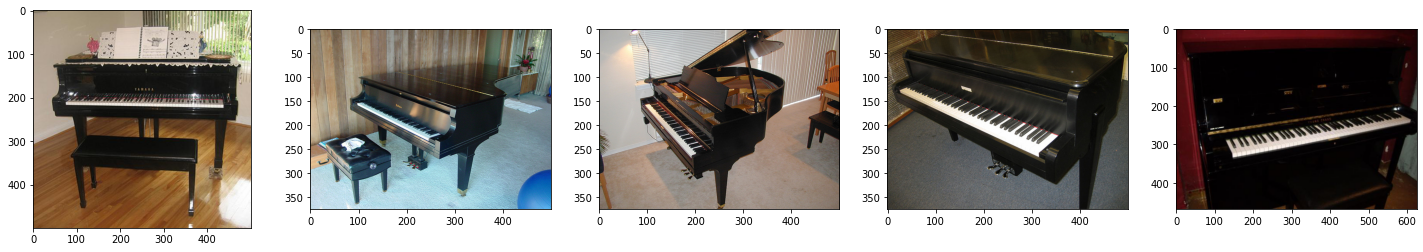

In [94]:
print(topk_candidates)
topk_filenames = [database_names_with_original[i] for i in topk_candidates]
show_image_list(topk_filenames)

# Can retain image from text ?

## experiment1

original text:  person
person
tensor([46881, 42833, 39133, 24772, 49515], device='cuda:0')


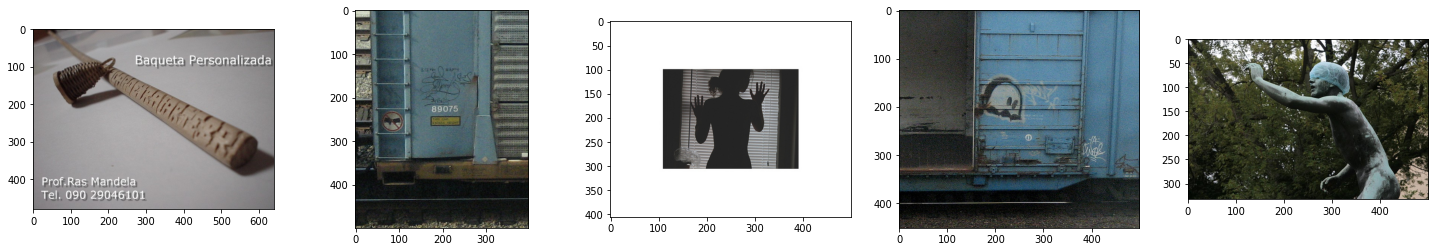

In [95]:
original_prompt = 'person'
temps = [1, 1]
text_features = get_language_embedding(original_prompt)
topk_candidates =  retain_topk(database_with_original, text_features, batch_size=64, topk=5)
print(original_prompt)

print(topk_candidates)
topk_filenames = [database_names_with_original[i] for i in topk_candidates]
show_image_list(topk_filenames)

## experiment2

original text:  man in the city
man in the city
tensor([ 3466,  3619,  3621, 18341, 33650], device='cuda:0')


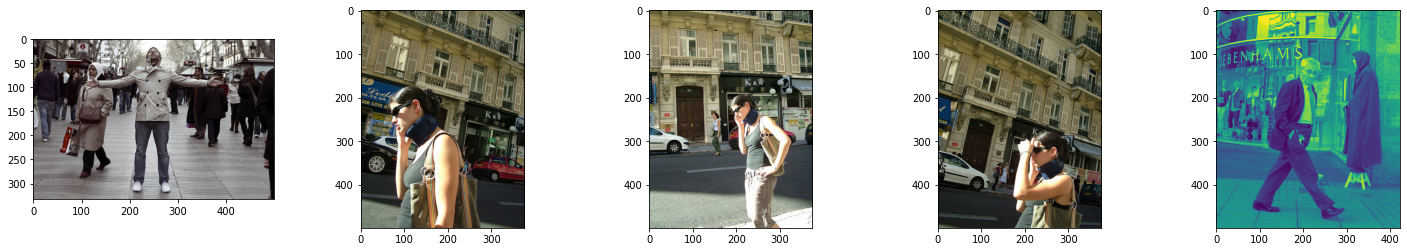

In [96]:
original_prompt = 'man in the city'
temps = [1, 1]
text_features = get_language_embedding(original_prompt)
topk_candidates =  retain_topk(database_with_original, text_features, batch_size=64, topk=5)
print(original_prompt)

print(topk_candidates)
topk_filenames = [database_names_with_original[i] for i in topk_candidates]
show_image_list(topk_filenames)

## free space

original text:  we are friends
we are friends
tensor([33680, 20281,  1902, 13369, 41634], device='cuda:0')


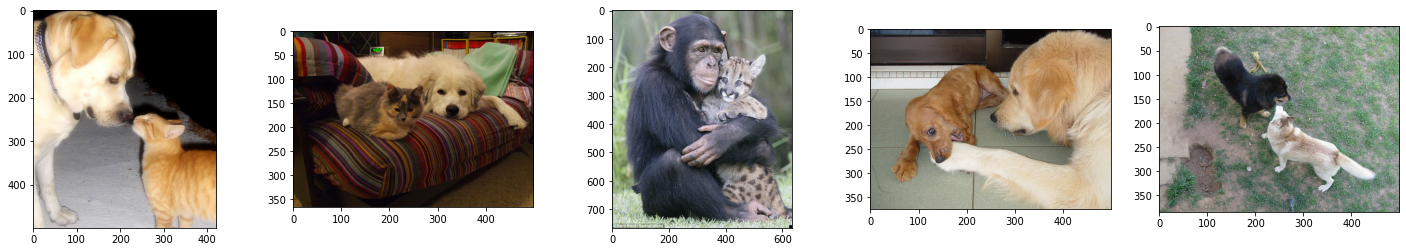

In [97]:
original_prompt = 'we are friends'
temps = [1, 1]
text_features = get_language_embedding(original_prompt)
topk_candidates =  retain_topk(database_with_original, text_features, batch_size=64, topk=5)
print(original_prompt)

print(topk_candidates)
topk_filenames = [database_names_with_original[i] for i in topk_candidates]
show_image_list(topk_filenames)

original text:  a photo of people
a photo of people
tensor([  138, 45630, 40852, 10354, 17629], device='cuda:0')


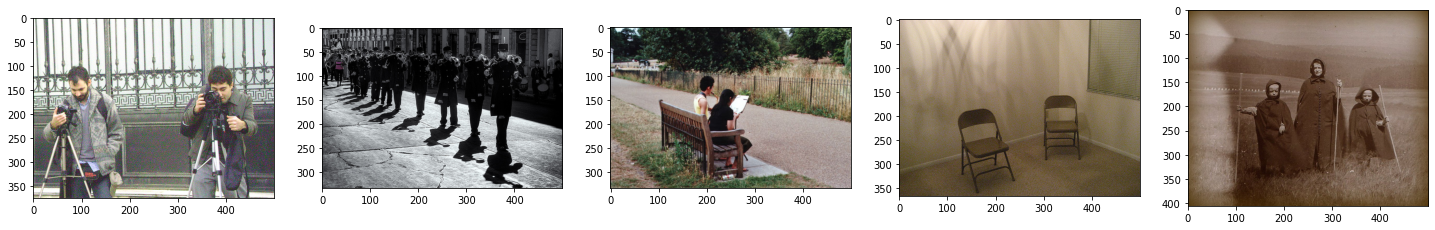

In [130]:
original_prompt = 'a photo of people'
temps = [1, 1]
text_features = get_language_embedding(original_prompt)
topk_candidates =  retain_topk(database_with_original, text_features, batch_size=64, topk=5)
print(original_prompt)

print(topk_candidates)
topk_filenames = [database_names_with_original[i] for i in topk_candidates]
show_image_list(topk_filenames)

# Synthesize image and text

In [98]:
preprocesses = [Normalize(dim=-1)]

## experiment1

original text:  person
tensor([50000, 11076, 49420, 11078, 49417], device='cuda:0')


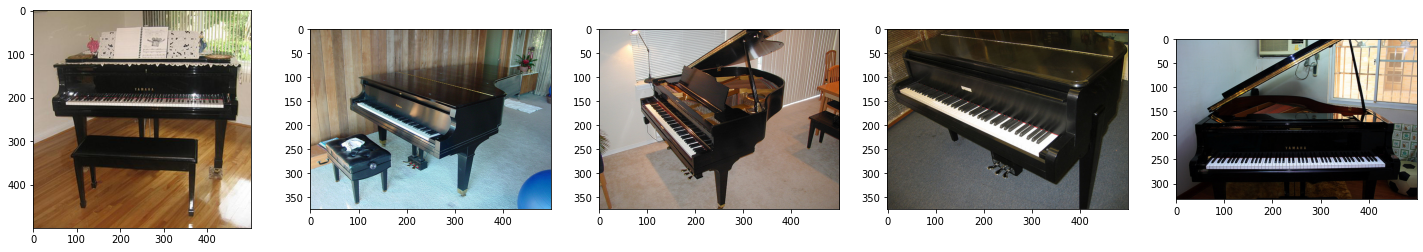

In [99]:
additional_prompt = 'person'
temps = [1, 1]
text_features = get_language_embedding(additional_prompt)
embedding_list = [text_features, image_features]

new_embeddings = embedding_synthesizer(embedding_list, preprocesses, temps=temps)
topk_candidates =  retain_topk(database_with_original, new_embeddings, batch_size=64, topk=5)

print(topk_candidates)
topk_filenames = [database_names_with_original[i] for i in topk_candidates]
show_image_list(topk_filenames)

## experiment2

original text:  on the fire
tensor([12110, 20391,  4721, 11076, 14303], device='cuda:0')


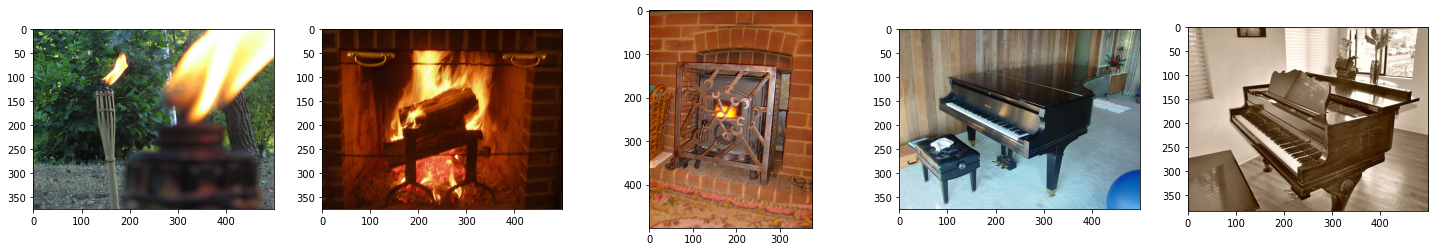

In [115]:
additional_prompt = 'on the fire'
temps = [1, 1]
scale = [3.4, 1]
text_features = get_language_embedding(additional_prompt)
embedding_list = [text_features, image_features]
# embedding_list = [text_features, text_features]

new_embeddings = embedding_synthesizer(embedding_list, preprocesses, temps=temps, scale=scale)
topk_candidates =  retain_topk(database_with_original, new_embeddings, batch_size=64, topk=5)

print(topk_candidates)
topk_filenames = [database_names_with_original[i] for i in topk_candidates]
show_image_list(topk_filenames)

## experiment3

original image: 


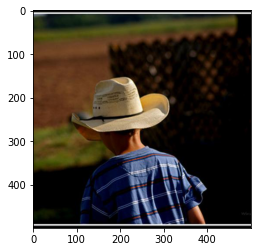

original text:  playing the guitar
tensor([26063, 26059, 17392, 29634, 48899], device='cuda:0')


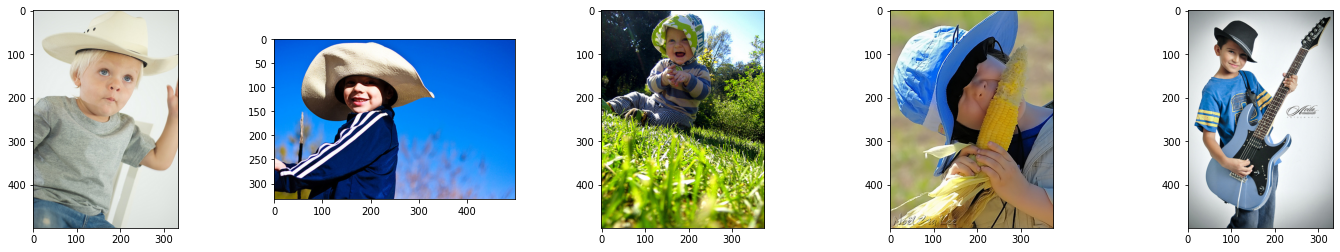

In [135]:
original_image_file_path = '/storage/dataset/ECoG/internal/GODv2-4/images_val/n03124170_13920.JPEG'
original_image_features = get_image_embedding(original_image_file_path, show=True)

additional_prompt = 'playing the guitar'
temps = [1, 1]
scale = [1.1, 1]
text_features = get_language_embedding(additional_prompt)
embedding_list = [text_features, original_image_features]
# embedding_list = [text_features, text_features]

new_embeddings = embedding_synthesizer(embedding_list, preprocesses, temps=temps, scale=scale)
topk_candidates =  retain_topk(database_with_original, new_embeddings, batch_size=64, topk=5)

print(topk_candidates)
topk_filenames = [database_names_with_original[i] for i in topk_candidates]
show_image_list(topk_filenames)

## experiment4

original image: 


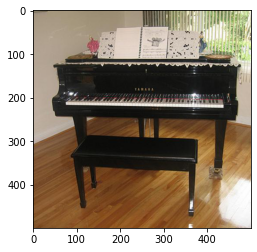

original text:  a photo of hawaii
tensor([50000, 11076, 49420, 14303, 49417], device='cuda:0')


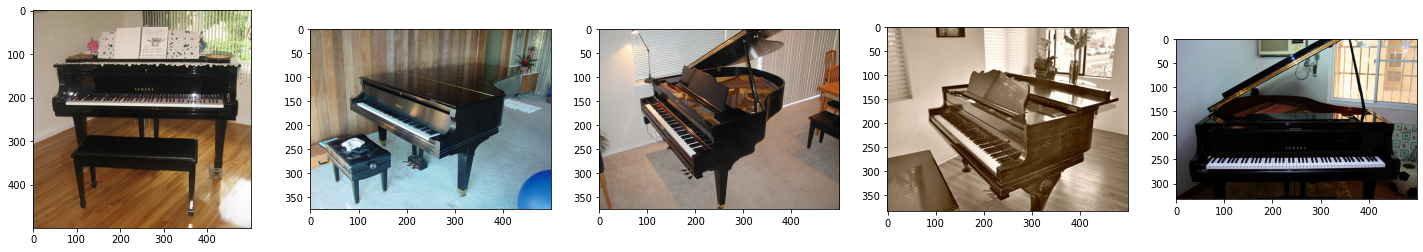

In [186]:
original_image_file_path = '/storage/dataset/ECoG/internal/GODv2-4/images_val/n01976957_13223.JPEG'
original_image_file_path = '/storage/dataset/ECoG/internal/GODv2-4/images_val/n03452741_24622.JPEG'
original_image_features = get_image_embedding(original_image_file_path, show=True)

additional_prompt = 'a photo of hawaii'
temps = [1, 1]
scale = [1, 1]
text_features = get_language_embedding(additional_prompt)
embedding_list = [text_features, original_image_features]
# embedding_list = [text_features, text_features]

new_embeddings = embedding_synthesizer(embedding_list, preprocesses, temps=temps, scale=scale)
topk_candidates =  retain_topk(database_with_original, new_embeddings, batch_size=64, topk=5)

print(topk_candidates)
topk_filenames = [database_names_with_original[i] for i in topk_candidates]
show_image_list(topk_filenames)

In [ ]:
original_image_file_path = '/storage/dataset/ECoG/internal/GODv2-4/images_val/n01976957_13223.JPEG'
original_image_file_path = '/storage/dataset/ECoG/internal/GODv2-4/images_val/n03452741_24622.JPEG'
original_image_features = get_image_embedding(original_image_file_path, show=True)

additional_prompt = 'a photo of hawaii'
temps = [1, 1]
scale = [1, 1]
text_features = get_language_embedding(additional_prompt)
embedding_list = [text_features, original_image_features]
# embedding_list = [text_features, text_features]

new_embeddings = embedding_synthesizer(embedding_list, preprocesses, temps=temps, scale=scale)
topk_candidates =  retain_topk(database_with_original, new_embeddings, batch_size=64, topk=5)

print(topk_candidates)
topk_filenames = [database_names_with_original[i] for i in topk_candidates]
show_image_list(topk_filenames)

# Synthesize text and text

original text:  we are friends
original text:  a photo of person
tensor([21772, 48921, 21382, 25029, 17948], device='cuda:0')


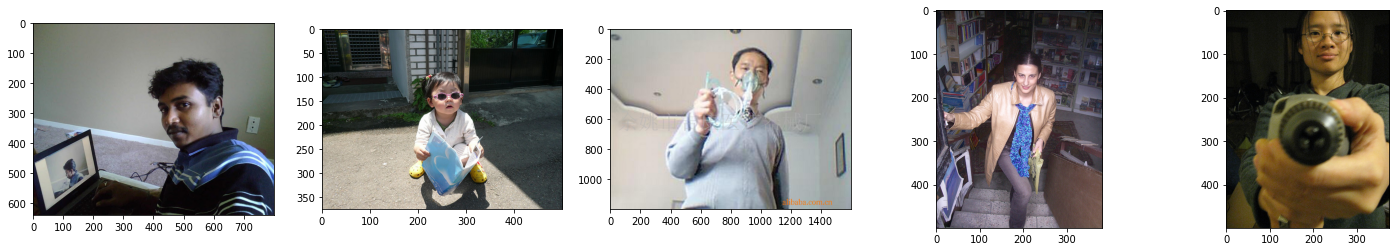

In [129]:
original_prompt = 'we are friends'
additional_prompt = 'a photo of person'

temps = [1, 1]
scale = [1, 1]
original_text_features = get_language_embedding(original_prompt)
additional_text_features = get_language_embedding(additional_prompt)
embedding_list = [original_text_features, additional_text_features]
# embedding_list = [additional_text_features, original_text_features]

new_embeddings = embedding_synthesizer(embedding_list, preprocesses, temps=temps, scale=scale)
topk_candidates =  retain_topk(database_with_original, new_embeddings, batch_size=64, topk=5)

print(topk_candidates)
topk_filenames = [database_names_with_original[i] for i in topk_candidates]
show_image_list(topk_filenames)

original text:  a photo of person
original text:  on the fire
tensor([12244, 48975, 12110,  5266,  4690], device='cuda:0')


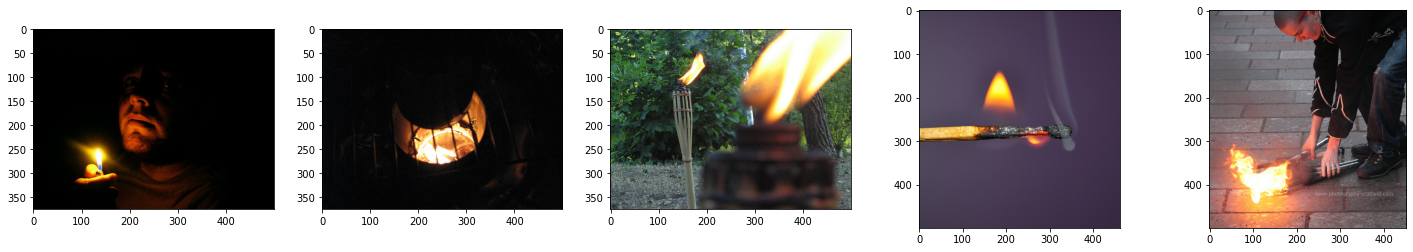

In [131]:
original_prompt = 'a photo of person'
additional_prompt = 'on the fire'

temps = [1, 1]
scale = [1.1,1]
original_text_features = get_language_embedding(original_prompt)
additional_text_features = get_language_embedding(additional_prompt)
embedding_list = [original_text_features, additional_text_features]
# embedding_list = [additional_text_features, original_text_features]

new_embeddings = embedding_synthesizer(embedding_list, preprocesses, temps=temps, scale=scale)
topk_candidates =  retain_topk(database_with_original, new_embeddings, batch_size=64, topk=5)

print(topk_candidates)
topk_filenames = [database_names_with_original[i] for i in topk_candidates]
show_image_list(topk_filenames)

original text:  a photo of person
original text:  playing the guitar
tensor([35468, 27856, 25980, 43815, 27854], device='cuda:0')


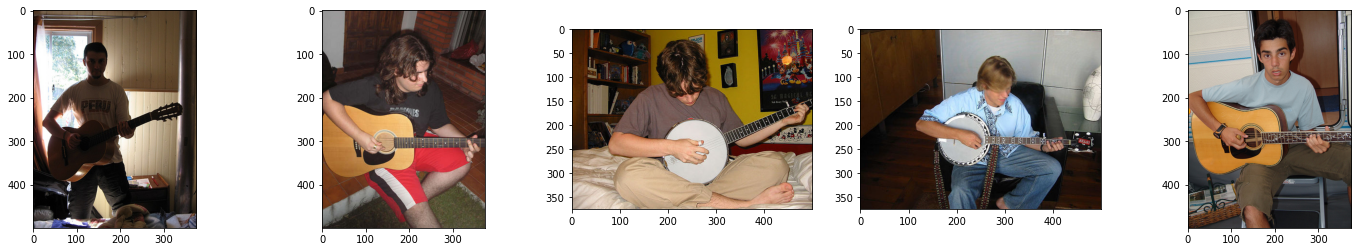

In [132]:
original_prompt = 'a photo of person'
additional_prompt = 'playing the guitar'

temps = [1, 1]
scale = [1.1,1]
original_text_features = get_language_embedding(original_prompt)
additional_text_features = get_language_embedding(additional_prompt)
embedding_list = [original_text_features, additional_text_features]
# embedding_list = [additional_text_features, original_text_features]

new_embeddings = embedding_synthesizer(embedding_list, preprocesses, temps=temps, scale=scale)
topk_candidates =  retain_topk(database_with_original, new_embeddings, batch_size=64, topk=5)

print(topk_candidates)
topk_filenames = [database_names_with_original[i] for i in topk_candidates]
show_image_list(topk_filenames)